# Feed Forward Regression


### Importing packages


In [2]:
import os

import numpy as np
import pandas as pd
import torch
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from utils import plot_mse, plot_pred_target

### Loading data


In [3]:
bidding_area = 1

df = pd.read_csv(f"data/NO{1}.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"])
df.set_index("timestamp", inplace=True)

df.head()

,temperature,consumption
timestamp,,
2017-05-01 00:00:00+00:00,2.1,3325.431995
2017-05-01 01:00:00+00:00,1.8,3344.690998
2017-05-01 02:00:00+00:00,3.2,3398.359002
2017-05-01 03:00:00+00:00,3.6,3430.220001
2017-05-01 04:00:00+00:00,3.4,3606.750000


### Add historic temperature


In [4]:
df["past_consumption"] = df["consumption"].shift(1)
df.rename(
    columns={"consumption": "next_consumption", "past_consumption": "consumption"},
    inplace=True,
)
df = df[["temperature", "consumption", "next_consumption"]]
df.dropna(inplace=True)

df.head()

,temperature,consumption,next_consumption
timestamp,,,
2017-05-01 01:00:00+00:00,1.8,3325.431995,3344.690998
2017-05-01 02:00:00+00:00,3.2,3344.690998,3398.359002
2017-05-01 03:00:00+00:00,3.6,3398.359002,3430.220001
2017-05-01 04:00:00+00:00,3.4,3430.220001,3606.750000
2017-05-01 05:00:00+00:00,3.1,3606.750000,3739.876998


### Adding time, day and year features


In [5]:
df["time_of_day"] = df.index.hour
df["day_of_week"] = df.index.dayofweek
df["day_of_year"] = df.index.dayofyear

df.head()

,temperature,consumption,next_consumption,time_of_day,day_of_week,day_of_year
timestamp,,,,,,
2017-05-01 01:00:00+00:00,1.8,3325.431995,3344.690998,1,0,121
2017-05-01 02:00:00+00:00,3.2,3344.690998,3398.359002,2,0,121
2017-05-01 03:00:00+00:00,3.6,3398.359002,3430.220001,3,0,121
2017-05-01 04:00:00+00:00,3.4,3430.220001,3606.750000,4,0,121
2017-05-01 05:00:00+00:00,3.1,3606.750000,3739.876998,5,0,121


### Splitting data


In [6]:
df_train, df_test = train_test_split(df, test_size=0.2, shuffle=False)
df_train, df_val = train_test_split(df_train, test_size=0.1)

### Normalizing training data


In [7]:
train_mean = df_train.mean()
train_std = df_train.std()

df_train = (df_train - train_mean) / train_std
df_val = (df_val - train_mean) / train_std
df_test = (df_test - train_mean) / train_std

In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11693 entries, 2022-08-31 19:00:00+00:00 to 2023-12-31 23:00:00+00:00
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   temperature       11693 non-null  float64
 1   consumption       11693 non-null  float64
 2   next_consumption  11693 non-null  float64
 3   time_of_day       11693 non-null  float64
 4   day_of_week       11693 non-null  float64
 5   day_of_year       11693 non-null  float64
dtypes: float64(6)
memory usage: 639.5 KB


### Converting to tensors


In [9]:
target_train = torch.tensor(df_train["next_consumption"].values.astype(np.float32))
features_train = torch.tensor(
    df_train.drop(columns="next_consumption").values.astype(np.float32)
)

target_val = torch.tensor(df_val["next_consumption"].values.astype(np.float32))
features_val = torch.tensor(
    df_val.drop(columns="next_consumption").values.astype(np.float32)
)

target_test = torch.tensor(df_test["next_consumption"].values.astype(np.float32))
features_test = torch.tensor(
    df_test.drop(columns="next_consumption").values.astype(np.float32)
)

### Create pytorch datasets and data loaders


In [10]:
train_tensor = TensorDataset(features_train, target_train)
train_loader = DataLoader(train_tensor, batch_size=64, shuffle=True)

val_tensor = TensorDataset(features_val, target_val)
val_loader = DataLoader(val_tensor, batch_size=64, shuffle=False)

test_tensor = TensorDataset(features_test, target_test)
test_loader = DataLoader(
    test_tensor, batch_size=25, shuffle=False
)  # 25 because one day has 24 hours

### Creating model


In [11]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


# Define model
class FeedForward(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(5, 24),
            nn.ReLU(),
            nn.Linear(24, 12),
            nn.ReLU(),
            nn.Linear(12, 6),
            nn.Linear(6, 1),
        )

    def forward(self, x):
        x = self.net(x)
        return x


model = FeedForward().to(device)
model

Using mps device


FeedForward(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=5, out_features=24, bias=True)
    (1): ReLU()
    (2): Linear(in_features=24, out_features=12, bias=True)
    (3): ReLU()
    (4): Linear(in_features=12, out_features=6, bias=True)
    (5): Linear(in_features=6, out_features=1, bias=True)
  )
)

### Loss function and optimizer


In [12]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

### Training


In [13]:
epochs = 20

losses = []
losses_show = []
val_losses = []

for e in range(epochs):
    epoch_loss = []

    for batch, (X, y) in enumerate(train_loader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y.view(-1, 1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        epoch_loss.append(loss.item())

        if len(losses) > 20:
            losses_show.append(sum(losses[-20:]) / 20)
        else:
            losses_show.append(losses[-1])

    val_loss = []
    for batch, (X, y) in enumerate(val_loader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y.view(-1, 1))
        val_loss.append(loss.item())

    avg_val_loss = sum(val_loss) / len(val_loss)
    print(f"Epoch {e+1}, Val Loss: {avg_val_loss}")

    val_losses.append(avg_val_loss)

models_directory = "models"

if not os.path.exists(models_directory):
    os.makedirs(models_directory)

torch.save(model.state_dict(), "models/fnn.pth")

Epoch 1, Val Loss: 0.00964403004744216
Epoch 2, Val Loss: 0.007940412085264217
Epoch 3, Val Loss: 0.007264211336528328
Epoch 4, Val Loss: 0.007393731581475082
Epoch 5, Val Loss: 0.007082938353493306
Epoch 6, Val Loss: 0.006390716012164547
Epoch 7, Val Loss: 0.00606032955850399
Epoch 8, Val Loss: 0.0055923697230330595
Epoch 9, Val Loss: 0.004594864868055526
Epoch 10, Val Loss: 0.00426785322063527
Epoch 11, Val Loss: 0.004324998074160838
Epoch 12, Val Loss: 0.004227688454242574
Epoch 13, Val Loss: 0.004063064452713808
Epoch 14, Val Loss: 0.003854692429052414
Epoch 15, Val Loss: 0.004046343266963959
Epoch 16, Val Loss: 0.0035693887809945925
Epoch 17, Val Loss: 0.003506474714487086
Epoch 18, Val Loss: 0.003439003121850358
Epoch 19, Val Loss: 0.003239524188904545
Epoch 20, Val Loss: 0.003257784784796673


### Plotting


658


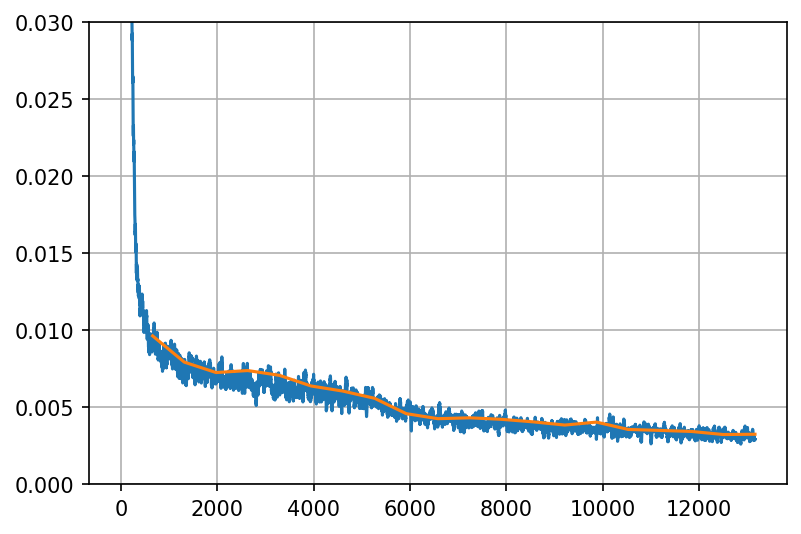

In [14]:
plt.figure(figsize=(6, 4), dpi=150)
plt.grid()
plt.ylim(0, 0.03)

print(len(losses_show) // len(val_losses))

plt.plot(range(len(losses_show)), losses_show, label="Train Loss")
plt.plot(
    range(
        len(losses_show) // len(val_losses),
        len(losses_show) + 1,
        len(losses_show) // len(val_losses),
    ),
    val_losses,
    label="Val Loss",
)
plt.show()

### Testing using Step-by-Step Strategy


In [15]:
model.eval()

with torch.no_grad():
    predictions = []

    for batch, (X, y) in enumerate(test_loader):
        X, y = X.to(device), y.to(device)

        preds = []
        i = 0
        pred = 0
        for f, t in zip(X, y):
            if i > 0:
                f[1] = pred
                pred = model(f)
                preds.append(pred.item())
            elif i == 0:
                pred = model(f)
                preds.append(pred.item())
            i += 1
        predictions.append([preds, y])

### Plotting predictions and targets


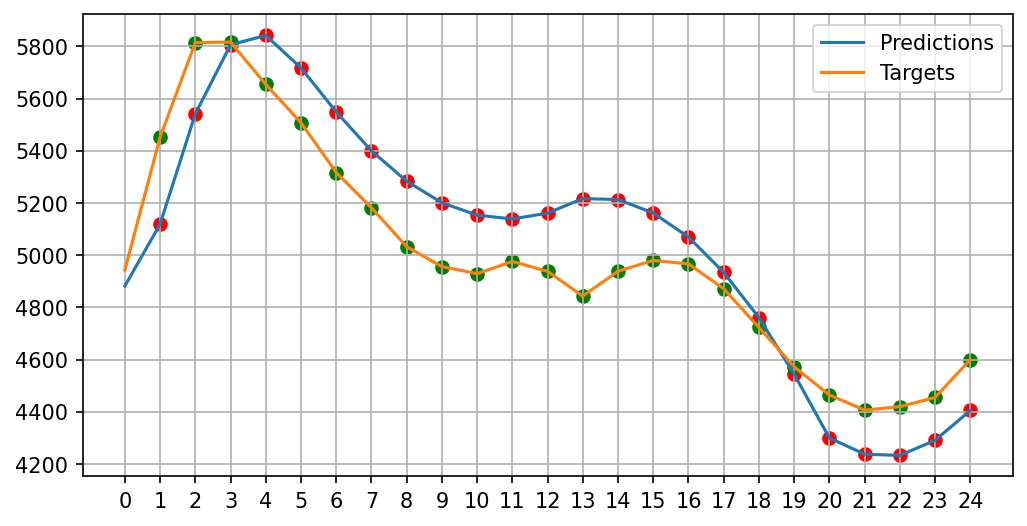

In [16]:
plot_pred_target(predictions, train_mean, train_std, 200)

### Plotting Mean Squared Error with Deviation


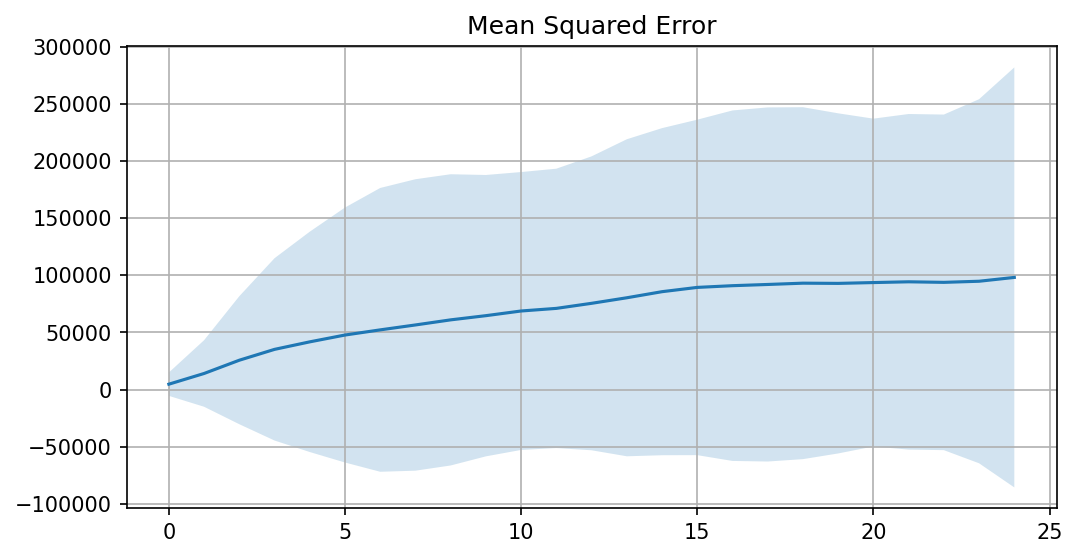

In [17]:
plot_mse(predictions, train_mean, train_std)